## Variational Autoencoder for handwritten digit generation

In [1]:
import numpy as np
from PIL import Image
from matplotlib import cm
import utils.utils as utils
from matplotlib import pyplot as plt
from variational_autoencoder import VariationalAutoencoder

%matplotlib inline


/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Data, constants, and functions for use throughout this notebook.
# File structure must be as follows in order for this cell to run:
#     root
#       |--variational_autoencoder.py
#       |--constants.py
#       |utils
#       |   |--utils.py
#       |
#       |--mnist
#           |--data
#               |--mnist-tf-testa.pkl
#               |--mnist-tf-testb.pkl
#               |--mnist-tf-train.pkl

PROJECT_NAME = 'mnist'
DEFAULT_MODEL_NAME = PROJECT_NAME + '_model'

# MNIST data, 50040 different 28 x 28 x 1 images (altogether a 4 tensor) with values from 0 to 255. 
DATA_DICT = utils.load_data(PROJECT_NAME, 'mnist-tf')
print('Input data shape:')
for key in DATA_DICT:
    print(key + ':', DATA_DICT[key]['inputs'].shape)
    
TRAIN_DATA_DICT = DATA_DICT['train']
VALID_DATA_DICT = DATA_DICT['testa']

INPUT_X = TRAIN_DATA_DICT['inputs'].shape[1] # x dimension of input images,
INPUT_Y = TRAIN_DATA_DICT['inputs'].shape[2] # y dimension of input images,
INPUT_Z = TRAIN_DATA_DICT['inputs'].shape[3] # z dimension (only one, images are black and white).

INPUTS_SHAPE_LIST = [INPUT_X, INPUT_Y, INPUT_Z]

NUM_SUBPLOTS = 15

VALID_LABELS_DICT = {}
for i, label in enumerate(VALID_DATA_DICT['target']):
    if label not in VALID_LABELS_DICT:
        VALID_LABELS_DICT[label] = []
    VALID_LABELS_DICT[label] += [i]
    
COLOR_LIST = cm.rainbow(np.linspace(0, 1, len(VALID_LABELS_DICT)))

def plot_encoded_validation_data(VAE, title):
    
    plt.clf()
    
#   Plot the encoded test datapoints, colored by number:
    for i in sorted(VALID_LABELS_DICT.keys()):
        encoded_data = VAE.encode(VALID_DATA_DICT['inputs'][VALID_LABELS_DICT[i]])[0]
        plt.scatter(encoded_data[:, 0], encoded_data[:, 1], color = COLOR_LIST[i], label = i)
        
#   Plot the circle containing 99% of the points:
    encoded_data = VAE.encode(VALID_DATA_DICT['inputs'])[0]
    center = np.mean(encoded_data, axis = 0)
    radii  = np.sort(np.linalg.norm(encoded_data - center, axis = 1))
    cutoff = int(0.99 * len(radii))
    radius = np.max(radii[:cutoff])
    circ = plt.Circle(center, radius = radius, color = 'r', linewidth = 2, fill = False)
    
#   Axes settings (superimpose the circle and set the scale):
    ax = plt.gca()
    ax.add_artist(circ)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axis('equal')
    ax.set_xlim(center[0] - radius - 1, center[0] + radius + 1)
    ax.set_ylim(center[1] - radius - 1, center[1] + radius + 1)

#   Set the title and legend:
    plt.title(title)
    plt.legend(bbox_to_anchor = (1.2, 1.1), loc = 'upper right')
    plt.show()
    
    return center, radius

def generate_numbers_from_inscribed_square(VAE, title, center, radius):
    
#   Generates fake handwritten digits from lattice sites in the red square that inscribes the red circle
#   created by the function 'plot_encoded_validation_data' above.
    
#   Get the vertices of the square that inscribes the red circle:
    upper_left = radius * np.array([-np.sqrt(0.5), np.sqrt(0.5)]  + [0] * (VAE.latent_shape[0] - 2)) + center
    lower_left = radius * np.array([-np.sqrt(0.5), -np.sqrt(0.5)] + [0] * (VAE.latent_shape[0] - 2)) + center
    upper_rght = radius * np.array([np.sqrt(0.5), np.sqrt(0.5)]   + [0] * (VAE.latent_shape[0] - 2)) + center
    lower_rght = radius * np.array([np.sqrt(0.5), -np.sqrt(0.5)]  + [0] * (VAE.latent_shape[0] - 2)) + center
    
#   Create an array of lattice points that fill this square:
    lattice_point_list = []
    for i in range(NUM_SUBPLOTS):
        
        left = upper_left * (1 - i / (NUM_SUBPLOTS - 1)) + lower_left * (i / (NUM_SUBPLOTS - 1))
        rght = upper_rght * (1 - i / (NUM_SUBPLOTS - 1)) + lower_rght * (i / (NUM_SUBPLOTS - 1))
        
        for j in range(NUM_SUBPLOTS):
            lattice_point_list += [left * (1 - j / (NUM_SUBPLOTS - 1)) + rght * (j / (NUM_SUBPLOTS - 1))]
    lattice_point_array = np.array(lattice_point_list)
            
#   Plot the lattice sites with latent variable values used to generate new numbers:
    plt.scatter(lattice_point_array[:, 0], lattice_point_array[:, 1], color = 'k')
    circ = plt.Circle(center, radius = radius, color = 'r', linewidth = 2, fill = False)
    
#   Axes settings (superimpose the circle and set the scale):
    ax = plt.gca()
    ax.add_artist(circ)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axis('equal')
    ax.set_xlim(center[0] - radius - 2, center[0] + radius + 2)
    ax.set_ylim(center[1] - radius - 2, center[1] + radius + 2)

#   Set the title:
    plt.title('Square lattice inscribed within the red disk')
    plt.show()
            
#   Generate fake handwritten digits from the latent vectors located at the lattice sites in 'lattice_point_array':
    fig, ax = plt.subplots(NUM_SUBPLOTS, NUM_SUBPLOTS, figsize = (15, 15))
    fig.suptitle(title, fontsize = 16)
            
    for subplot_num, lattice_point in enumerate(lattice_point_array):
        
#       Generate the face handwritten digit, using the latent vector at 'lattice_point':
        new_encoded_number = np.expand_dims(lattice_point, axis = 0)
        new_number = VAE.decode(new_encoded_number)

        plt.subplot(NUM_SUBPLOTS, NUM_SUBPLOTS, subplot_num + 1)
        plt.imshow(np.squeeze(new_number[0], axis = 2), cmap = 'Greys')
        plt.axis('off')

    plt.show()


Input data shape:
train: (50040, 28, 28, 1)
testa: (9960, 28, 28, 1)
testb: (10000, 28, 28, 1)


##  Tensorboard graph for an autoencoder with fully connected layers

In [3]:
# Check out the computational graph with tensorboard:

encoder_list = [{'layer_type': 'reshape'},
                {'layer_type': 'full_cn', 'output_shape': [500], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [250], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [2]}]

decoder_list = [{'layer_type': 'full_cn', 'output_shape': [250], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [500], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [int(np.prod(INPUTS_SHAPE_LIST))], 'activation': 'sigmoid'},
                {'layer_type': 'reshape', 'output_shape': INPUTS_SHAPE_LIST}]

model_details_dict = {'encoder_list': encoder_list,
                      'decoder_list': decoder_list,
                      'inputs_shape_list': INPUTS_SHAPE_LIST,
                      'project_name': PROJECT_NAME,
                      'model_name': DEFAULT_MODEL_NAME,
                      'is_variational': True} # True = variational autoencoder, False = autoencoder.

with VariationalAutoencoder(model_details_dict) as VAE:
    
    VAE.show_graph()
        

In [4]:
# Get the layer shapes for a newly created model:

encoder_list = [{'layer_type': 'reshape'},
                {'layer_type': 'full_cn', 'output_shape': [500], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [250], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [2]}]

decoder_list = [{'layer_type': 'full_cn', 'output_shape': [250], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [500], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [int(np.prod(INPUTS_SHAPE_LIST))], 'activation': 'sigmoid'},
                {'layer_type': 'reshape', 'output_shape': INPUTS_SHAPE_LIST}]

model_details_dict = {'encoder_list': encoder_list,
                      'decoder_list': decoder_list,
                      'inputs_shape_list': INPUTS_SHAPE_LIST,
                      'project_name': PROJECT_NAME,
                      'model_name': DEFAULT_MODEL_NAME,
                      'is_variational': True} # True = variational autoencoder, False = autoencoder.

with VariationalAutoencoder(model_details_dict) as VAE:
    
    print('Inputs shape:\n', VAE.inputs_shape, '\n')

    print('Encoder shape list:')
    for item in VAE.encoder_shape_list:
        print(item)
    print('\n')
    
    print('Latent shape:\n', VAE.latent_shape, '\n')
    
    print('Decoder shape list:')
    for item in VAE.decoder_shape_list:
        print(item)
    print('\n')
    
    print('Output shape:\n', VAE.output_shape, '\n')
    
    print('Altogether, the layer shape list for the entire variational autoencoder:')
    for item in VAE.layer_shape_list:
        print(item)


Inputs shape:
 [28 28  1] 

Encoder shape list:
[28 28  1]
[784]
[500]
[250]
[2]


Latent shape:
 [2] 

Decoder shape list:
[2]
[250]
[500]
[784]
[28 28  1]


Output shape:
 [28 28  1] 

Altogether, the layer shape list for the entire variational autoencoder:
[28 28  1]
[784]
[500]
[250]
[2]
[250]
[500]
[784]
[28 28  1]


## Autoencoder with fully connected layers and two-dimensional latent space

Train an autoencoder with
    1. encoder = three fully connected layers,
    2. decoder = three fully connected layers.
    3. latent space dimension = 2
 


In [5]:
# Train a new fully connected model:

encoder_list = [{'layer_type': 'reshape'},
                {'layer_type': 'full_cn', 'output_shape': [500], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [250], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [2]}]

decoder_list = [{'layer_type': 'full_cn', 'output_shape': [250], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [500], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [int(np.prod(INPUTS_SHAPE_LIST))], 'activation': 'sigmoid'},
                {'layer_type': 'reshape', 'output_shape': INPUTS_SHAPE_LIST}]

model_details_dict = {'encoder_list': encoder_list,
                      'decoder_list': decoder_list,
                      'inputs_shape_list': INPUTS_SHAPE_LIST,
                      'project_name': PROJECT_NAME,
                      'model_name': DEFAULT_MODEL_NAME,
                      'is_variational': False}

with VariationalAutoencoder(model_details_dict) as VAE:
    
    model_name_1 = VAE.model_name
    
    print('Training model {} of project {}.'.format(VAE.model_name, VAE.project_name))
    
    VAE.train_model(TRAIN_DATA_DICT['inputs'], num_training_epochs = 40)
    

Training model mnist_model_2019-04-18T14-38-57.008597 of project mnist.


Epoch 5 of 40 completed. Total time elapsed so far: 28.834
----------------------------------------------------------
Loss over all input data: 141.994
Time to train last epoch: 5.549


Epoch 10 of 40 completed. Total time elapsed so far: 56.922
-----------------------------------------------------------
Loss over all input data: 136.842
Time to train last epoch: 5.517


Epoch 15 of 40 completed. Total time elapsed so far: 84.37
----------------------------------------------------------
Loss over all input data: 134.278
Time to train last epoch: 5.637


Epoch 20 of 40 completed. Total time elapsed so far: 111.668
------------------------------------------------------------
Loss over all input data: 132.988
Time to train last epoch: 5.541


Epoch 25 of 40 completed. Total time elapsed so far: 140.83
-----------------------------------------------------------
Loss over all input data: 132.127
Time to train last epo

Now, let's plot the two-dimensional encoding distribution of numbers in the validation set. In the following, we see three plots:
1. The first plot shows the encoding distribution of numbers in the validation set. The red circle contains 99% of all of the points in this distribution. Because the distribution is not isotropic (as a result of using a plain autoencoder), the red circle contains a lot of open space that is not near the distribution.
2. The second plot shows a square lattice inscribed within the red circle of the previous plot.
3. The thrid plot shows the numbers that result from passing the coordinates of each lattice site in the second plot through the decoder. Notice that number generated from areas within the red circle but far from the point distribution are sometimes hard to recognize as numbers. Perhaps this effect is alleviated if we use a variational autencoder with a KL-divergence term in the loss function.

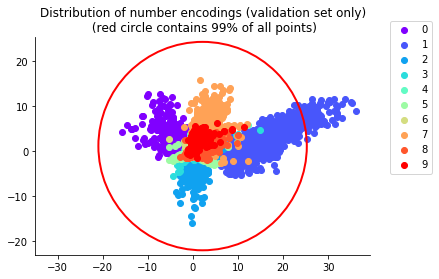

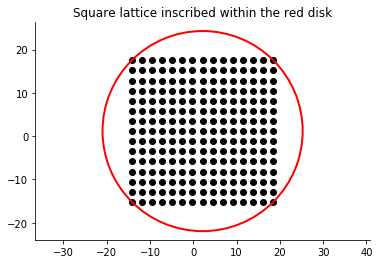

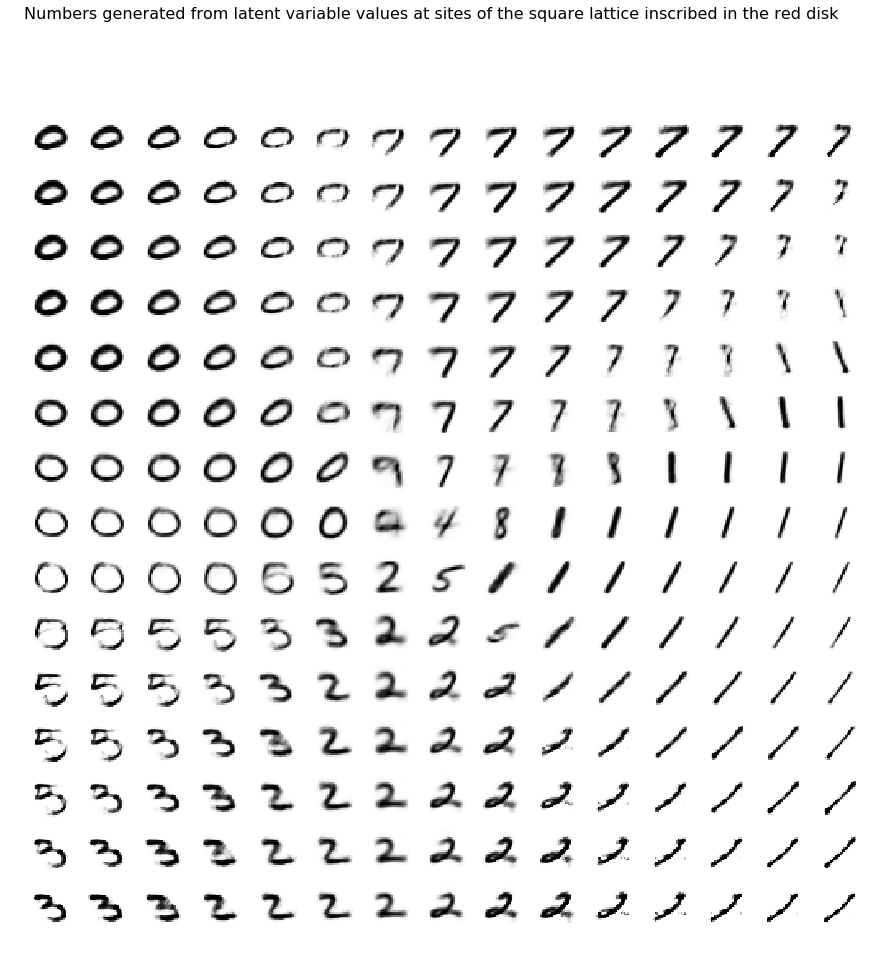

In [6]:
model_details_dict = {'model_name': model_name_1,
                      'project_name': PROJECT_NAME}

with VariationalAutoencoder(model_details_dict) as VAE:
    
#   Plot the encoded validation datapoints, colored by number (the red circle encloses 99% of all points):
    title = 'Distribution of number encodings (validation set only)\n (red circle contains 99% of all points)'
    center, radius = plot_encoded_validation_data(VAE, title)
    
#   Generate new numbers from the NUM_SUBPLOTS x NUM_SUBPLOTS square lattice inscribed into the red circle:
    title = 'Numbers generated from latent variable values at sites of the square lattice inscribed in the red disk'
    generate_numbers_from_inscribed_square(VAE, title, center, radius)
    

## Variational autoencoder with fully connected layers and two-dimensional latent space

Train a variational autoencoder with
    1. encoder = three fully connected layers,
    2. decoder = three fully connected layers.'
    3. latent space dimension = 2
    

In [7]:
# Train a new fully connected model:

encoder_list = [{'layer_type': 'reshape'},
                {'layer_type': 'full_cn', 'output_shape': [500], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [250], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [2]}]

decoder_list = [{'layer_type': 'full_cn', 'output_shape': [250], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [500], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [int(np.prod(INPUTS_SHAPE_LIST))], 'activation': 'sigmoid'},
                {'layer_type': 'reshape', 'output_shape': INPUTS_SHAPE_LIST}]

model_details_dict = {'encoder_list': encoder_list,
                      'decoder_list': decoder_list,
                      'inputs_shape_list': INPUTS_SHAPE_LIST,
                      'project_name': PROJECT_NAME,
                      'model_name': DEFAULT_MODEL_NAME,
                      'is_variational': True}

with VariationalAutoencoder(model_details_dict) as VAE:
    
    model_name_2 = VAE.model_name
    
    print('Training model {} of project {}.'.format(VAE.model_name, VAE.project_name))
    
    VAE.train_model(TRAIN_DATA_DICT['inputs'], num_training_epochs = 40)
    

Training model mnist_model_2019-04-18T14-43-34.516211 of project mnist.


Epoch 5 of 40 completed. Total time elapsed so far: 30.97
---------------------------------------------------------
Loss over all input data: 77.825
Time to train last epoch: 6.137


Epoch 10 of 40 completed. Total time elapsed so far: 57.101
-----------------------------------------------------------
Loss over all input data: 75.742
Time to train last epoch: 5.195


Epoch 15 of 40 completed. Total time elapsed so far: 83.257
-----------------------------------------------------------
Loss over all input data: 74.674
Time to train last epoch: 5.255


Epoch 20 of 40 completed. Total time elapsed so far: 109.368
------------------------------------------------------------
Loss over all input data: 74.097
Time to train last epoch: 5.188


Epoch 25 of 40 completed. Total time elapsed so far: 135.431
------------------------------------------------------------
Loss over all input data: 73.624
Time to train last epoch:

Now, let's plot the two-dimensional encoding distribution of numbers in the validation set. In the following, we see three plots:
1. The first plot shows the encoding distribution of numbers in the validation set. The red circle contains 99% of all of the points in this distribution. Because the distribution is nearly isotropic (as a result of using a variational autoencoder with a KL-divergence term in its loss function), the red circle contains little open space that is not near the distribution.
2. The second plot shows a square lattice inscribed within the red circle of the previous plot.
3. The thrid plot shows the numbers that result from passing the coordinates of each lattice site in the second plot through the decoder. Notice that the numbers generated almost always look like numbers, a result of the lack of open space in the red circle.

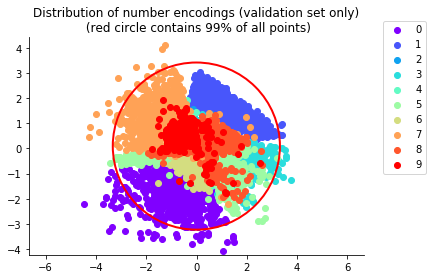

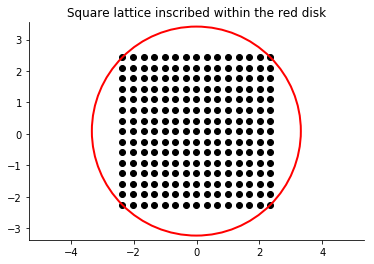

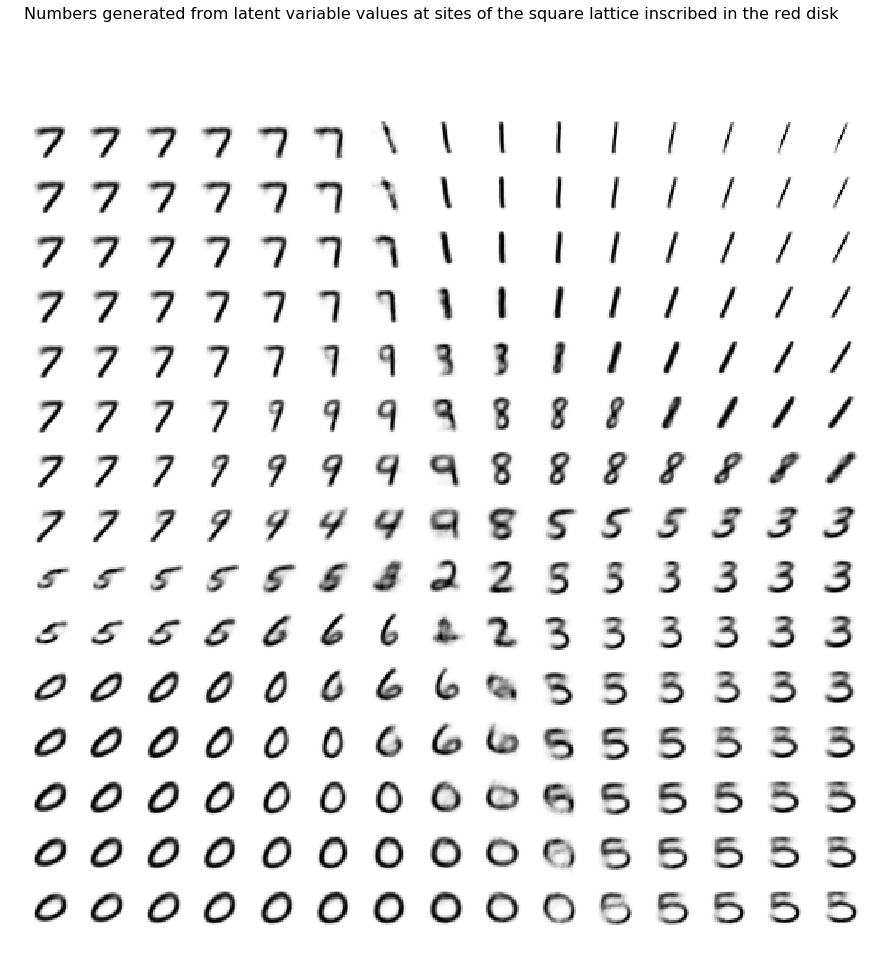

In [8]:
model_details_dict = {'model_name': model_name_2,
                      'project_name': PROJECT_NAME}

with VariationalAutoencoder(model_details_dict) as VAE:
    
#   Plot the encoded validation datapoints, colored by number (the red circle encloses 99% of all points):
    title = 'Distribution of number encodings (validation set only)\n (red circle contains 99% of all points)'
    center, radius = plot_encoded_validation_data(VAE, title)
    
#   Generate new numbers from the NUM_SUBPLOTS x NUM_SUBPLOTS square lattice inscribed into the red circle:
    title = 'Numbers generated from latent variable values at sites of the square lattice inscribed in the red disk'
    generate_numbers_from_inscribed_square(VAE, title, center, radius)
    

## Autoencoder with fully connected layers and ten-dimensional latent space

Train an autoencoder with
    1. encoder = three fully connected layers,
    2. decoder = three fully connected layers.
    3. latent space dimension = 10


In [9]:
# Train a new fully connected model:

encoder_list = [{'layer_type': 'reshape'},
                {'layer_type': 'full_cn', 'output_shape': [500], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [250], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [10]}]

decoder_list = [{'layer_type': 'full_cn', 'output_shape': [10],  'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [250], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [int(np.prod(INPUTS_SHAPE_LIST))], 'activation': 'sigmoid'},
                {'layer_type': 'reshape', 'output_shape': INPUTS_SHAPE_LIST}]

model_details_dict = {'encoder_list': encoder_list,
                      'decoder_list': decoder_list,
                      'inputs_shape_list': INPUTS_SHAPE_LIST,
                      'project_name': PROJECT_NAME,
                      'model_name': DEFAULT_MODEL_NAME,
                      'is_variational': False}

with VariationalAutoencoder(model_details_dict) as VAE:
    
    model_name_3 = VAE.model_name

    print('Training model {} of project {}.'.format(VAE.model_name, VAE.project_name))
    
    VAE.train_model(TRAIN_DATA_DICT['inputs'], num_training_epochs = 40)
    

Training model mnist_model_2019-04-18T14-47-43.963312 of project mnist.


Epoch 5 of 40 completed. Total time elapsed so far: 23.786
----------------------------------------------------------
Loss over all input data: 206.213
Time to train last epoch: 4.578


Epoch 10 of 40 completed. Total time elapsed so far: 46.16
----------------------------------------------------------
Loss over all input data: 206.176
Time to train last epoch: 4.631


Epoch 15 of 40 completed. Total time elapsed so far: 65.409
-----------------------------------------------------------
Loss over all input data: 206.139
Time to train last epoch: 3.621


Epoch 20 of 40 completed. Total time elapsed so far: 84.244
-----------------------------------------------------------
Loss over all input data: 206.109
Time to train last epoch: 3.651


Epoch 25 of 40 completed. Total time elapsed so far: 102.611
------------------------------------------------------------
Loss over all input data: 206.087
Time to train last epo

Now, let's plot the first two coordinates of the ten-dimensional encoding distribution of numbers in the validation set. In the following, we see three plots:
1. The first plot shows the first two coordinates of the encoding distribution of numbers in the validation set. The red circle is centered at the center of mass of the full ten-dimensional distribution, and its radius equals the radius of the ten-dimensional hypersphere with the same center and containing 99% of the points in this distribution. Because the distribution is not isotropic in all 10 dimensions (as a result of using a plain autoencoder) (but is nearly isotropic in the two dimensions shown here), the red circle contains a lot of open space that is not near the distribution.
2. The second plot shows a square lattice inscribed within the red circle of the previous plot.
3. The thrid plot shows the numbers that result from passing the two coordinates of each lattice site in the second plot through the decoder (the other 10 - 2 = 8 coordinates of the ten-dimensional latent space are set to zero). Notice that number generated from areas within the red circle but far from the point distribution are hard to recognize as numbers (much harder than the case of the plain autoencoder with two-dimensional latent space). Perhaps this effect is alleviated if we use a variational autencoder with a KL-divergence term in the loss function.

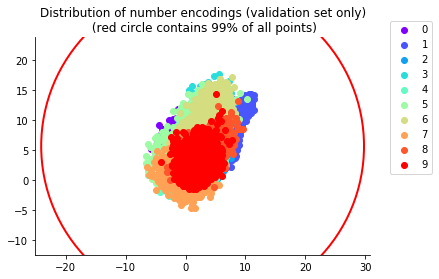

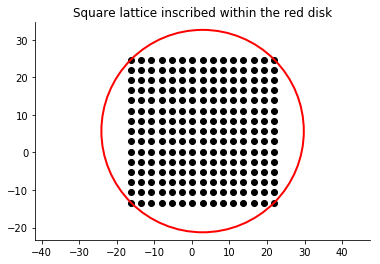

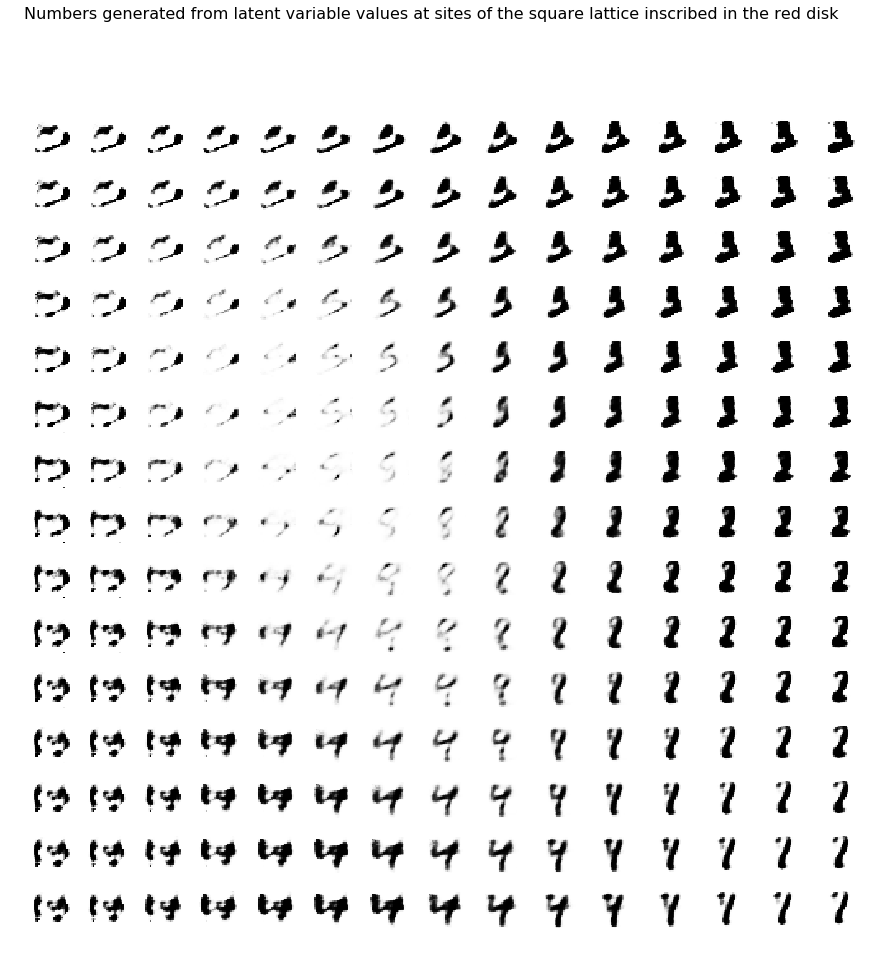

In [10]:
model_details_dict = {'model_name': model_name_3,
                      'project_name': PROJECT_NAME}
    
with VariationalAutoencoder(model_details_dict) as VAE:
    
#   Plot the encoded validation datapoints, colored by number (the red circle encloses 99% of all points):
    title = 'Distribution of number encodings (validation set only)\n (red circle contains 99% of all points)'
    center, radius = plot_encoded_validation_data(VAE, title)
    
#   Generate new numbers from the NUM_SUBPLOTS x NUM_SUBPLOTS square lattice inscribed into the red circle:
    title = 'Numbers generated from latent variable values at sites of the square lattice inscribed in the red disk'
    generate_numbers_from_inscribed_square(VAE, title, center, radius)
    

## Variational autoencoder with fully connected layers and ten-dimensional latent space

Train a variational autoencoder with
    1. encoder = three fully connected layers,
    2. decoder = three fully connected layers.
    3. latent space dimension = 10
 


In [11]:
# Train a new fully connected model:

encoder_list = [{'layer_type': 'reshape'},
                {'layer_type': 'full_cn', 'output_shape': [500], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [250], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [10]}]

decoder_list = [{'layer_type': 'full_cn', 'output_shape': [10],  'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [250], 'activation': 'relu'},
                {'layer_type': 'full_cn', 'output_shape': [int(np.prod(INPUTS_SHAPE_LIST))], 'activation': 'sigmoid'},
                {'layer_type': 'reshape', 'output_shape': INPUTS_SHAPE_LIST}]

model_details_dict = {'encoder_list': encoder_list,
                      'decoder_list': decoder_list,
                      'inputs_shape_list': INPUTS_SHAPE_LIST,
                      'project_name': PROJECT_NAME,
                      'model_name': DEFAULT_MODEL_NAME,
                      'is_variational': True}

with VariationalAutoencoder(model_details_dict) as VAE:
    
    model_name_4 = VAE.model_name

    print('Training model {} of project {}.'.format(VAE.model_name, VAE.project_name))
    
    VAE.train_model(TRAIN_DATA_DICT['inputs'], num_training_epochs = 40)
    

Training model mnist_model_2019-04-18T14-50-56.550013 of project mnist.


Epoch 5 of 40 completed. Total time elapsed so far: 18.909
----------------------------------------------------------
Loss over all input data: 69.678
Time to train last epoch: 3.7


Epoch 10 of 40 completed. Total time elapsed so far: 38.193
-----------------------------------------------------------
Loss over all input data: 66.592
Time to train last epoch: 3.686


Epoch 15 of 40 completed. Total time elapsed so far: 57.336
-----------------------------------------------------------
Loss over all input data: 65.167
Time to train last epoch: 4.003


Epoch 20 of 40 completed. Total time elapsed so far: 76.333
-----------------------------------------------------------
Loss over all input data: 64.293
Time to train last epoch: 3.719


Epoch 25 of 40 completed. Total time elapsed so far: 95.771
-----------------------------------------------------------
Loss over all input data: 63.697
Time to train last epoch: 3.7

Now, let's plot the first two coordinates of the ten-dimensional encoding distribution of numbers in the validation set. In the following, we see three plots:
1. The first plot shows the first two coordinates of the encoding distribution of numbers in the validation set. The red circle is centered at the center of mass of the full ten-dimensional distribution, and its radius equals the radius of the ten-dimensional hypersphere with the same center and containing 99% of the points in this distribution. Because the distribution is nearly isotropic in all ten dimension (as a result of using a variational autoencoder with a KL-divergence term in its loss function), the red circle contains little open space that is not near the distribution.
2. The second plot shows a square lattice inscribed within the red circle of the previous plot.
3. The thrid plot shows the numbers that result from passing the two coordinates of each lattice site in the second plot through the decoder (the other 10 - 2 = 8 coordinates of the latent space are set to zero). Notice that the numbers generated almost always look like numbers, a result of the lack of open space in the red circle.

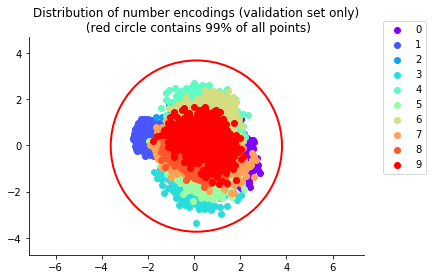

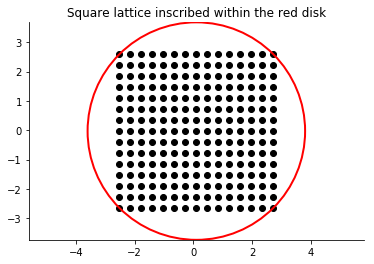

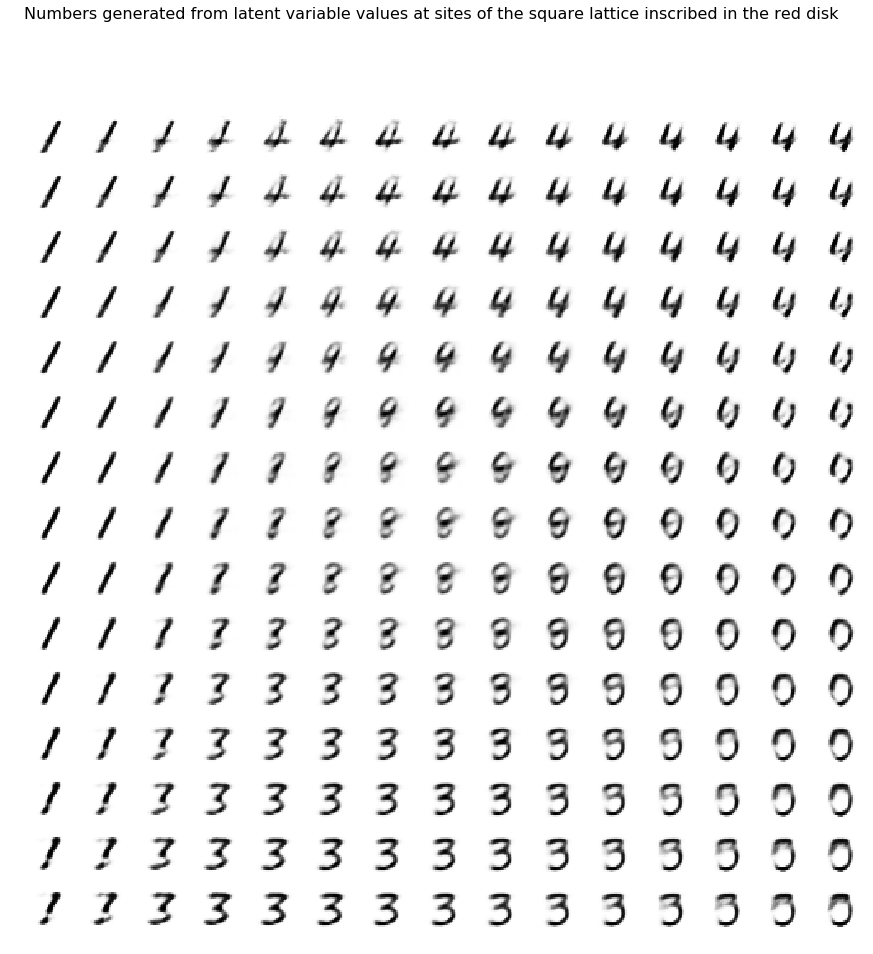

In [12]:
model_details_dict = {'model_name': model_name_4,
                      'project_name': PROJECT_NAME}

with VariationalAutoencoder(model_details_dict) as VAE:
    
#   Plot the encoded validation datapoints, colored by number (the red circle encloses 99% of all points):
    title = 'Distribution of number encodings (validation set only)\n (red circle contains 99% of all points)'
    center, radius = plot_encoded_validation_data(VAE, title)
    
#   Generate new numbers from the NUM_SUBPLOTS x NUM_SUBPLOTS square lattice inscribed into the red circle:
    title = 'Numbers generated from latent variable values at sites of the square lattice inscribed in the red disk'
    generate_numbers_from_inscribed_square(VAE, title, center, radius)


## Variational Autoencoder with convolution layers

Train a new variational autoencoder with
    1. encoder = two convolution layers,
    2. decoder = two deconvolution layers.

In [13]:
# Train a new convolutional model:

encoder_list = [{'layer_type': 'convolu', 'kernel_shape': [5, 5], 'output_chann': [32], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'convolu', 'kernel_shape': [3, 3], 'output_chann': [4],  'pool_shape': [2, 2]}]

decoder_list = [{'layer_type': 'deconvo', 'kernel_shape': [3, 3], 'output_chann': [32], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'deconvo', 'kernel_shape': [5, 5], 'output_chann': [1],  'pool_shape': [2, 2], 'activation': 'sigmoid'}]

model_details_dict = {'encoder_list': encoder_list,
                      'decoder_list': decoder_list,
                      'inputs_shape_list': INPUTS_SHAPE_LIST,
                      'project_name': PROJECT_NAME,
                      'model_name': DEFAULT_MODEL_NAME}

with VariationalAutoencoder(model_details_dict) as VAE:
    
    model_name_5 = VAE.model_name

    print('Training model {} of project {}.'.format(VAE.model_name, VAE.project_name))
    
    VAE.train_model(TRAIN_DATA_DICT['inputs'], num_training_epochs = 40)
    

Training model mnist_model_2019-04-18T14-59-47.869971 of project mnist.


Epoch 5 of 40 completed. Total time elapsed so far: 451.875
-----------------------------------------------------------
Loss over all input data: 94.938
Time to train last epoch: 86.841


Epoch 10 of 40 completed. Total time elapsed so far: 891.485
------------------------------------------------------------
Loss over all input data: 92.948
Time to train last epoch: 91.69


Epoch 15 of 40 completed. Total time elapsed so far: 1371.579
-------------------------------------------------------------
Loss over all input data: 92.284
Time to train last epoch: 88.236


Epoch 20 of 40 completed. Total time elapsed so far: 1809.342
-------------------------------------------------------------
Loss over all input data: 91.937
Time to train last epoch: 87.479


Epoch 25 of 40 completed. Total time elapsed so far: 2234.777
-------------------------------------------------------------
Loss over all input data: 91.731
Time to 

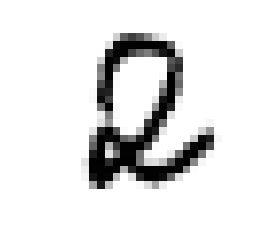

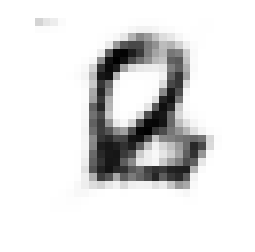

In [14]:
# Reconstruct the 10:th digit in the validation dataset by passing it through the variational autoencoder:

model_details_dict = {'model_name': model_name_5,
                      'project_name': PROJECT_NAME}

image_num = 10

with VariationalAutoencoder(model_details_dict) as VAE:
    
    input_digit = VALID_DATA_DICT['inputs'][image_num: image_num + 1]
    faked_digit = VAE.reform(VALID_DATA_DICT['inputs'][image_num: image_num + 1])

    for image in [input_digit, faked_digit]:
        plt.imshow(np.squeeze(image[0], axis = 2), cmap = 'Greys')
        plt.axis('off')
        plt.show()
